In [25]:
!pip3 install --user opencv-python

In [86]:
from itertools import product
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.io as skio
from PIL import Image

# Input images

In [93]:
data = Path("data")
out_dir = Path("output")
out_dir.mkdir(parents=True, exist_ok=True)
images_low_res = list(data.glob("*.jpg"))
print(f"number of images = {len(images)}")

number of images = 3


In [94]:
images_high_res = list(data.glob("*.tif"))
print(f"number of images = {len(images)}")

number of images = 3


# Aligning Channels

In [30]:
# returns a sub_matrix extracted from IM
def sub_image(im, start, h, w, r_offset=0, c_offset=0, pad_val: float = np.inf):
    # initialize entries of result to 'inf'
    result = np.full((h - 2 * r_offset, w - 2 * c_offset), pad_val)

    # extract sub_matrix from IM
    a = im[
        start[0] + r_offset : start[0] + h - r_offset,
        start[1] + c_offset : start[1] + w - c_offset,
    ]
    result[: a.shape[0], : a.shape[1]] = a
    return result

## Alignment Algorithms

#### 1. Basic

In [58]:
# Returns alignment index by simply dividing the image in 3
def align_basic(im):
    num_rows = im.shape[0]
    G_start = num_rows // 3  # floor division to get integer indices
    R_start = num_rows // 3 * 2
    return G_start, R_start

#### 2. SSD

In [9]:
# Returns the ssd between matrix a and matrix b
def ssd(a, b):
    return np.sum((a - b) ** 2)


# Returns row displacements that give best result
def align_ssd(
    im,
    B_start=0,
    displacement: int = 10,
    r_offset: int = 10,
    c_offset: int = 10,
):
    h, w = im.shape[0] // 3, im.shape[1]
    b = sub_image(im, B_start, h, w, r_offset, c_offset)
    G_start = h
    R_start = h * 2
    # find displacement for G channel
    score = {}
    for d in range(1, displacement):
        g = sub_image(im, G_start, h, w, r_offset, c_offset)
        score[d] = ssd(b, g)
    G_start = min(score)
    # find displacement for R channel
    score = {}
    for d in range(1, displacement):
        r = sub_image(im, R_start, h, w, r_offset, c_offset)
        score[d] = ssd(b, r)
    R_start = min(score)
    return G_start, R_start

#### 3. NCC

In [10]:
# Returns the ncc between matrix a and matrix b
def ncc(a, b):
    s = np.array([r_a @ r_b for r_a in a for r_b in b])
    return np.sum(s)


# Returns row displacements that give best result
def align_ncc(
    im,
    B_start=0,
    displacement: int = 10,
    r_offset: int = 10,
    c_offset: int = 10,
):
    b = sub_image(im, B_start, h, w, r_offset, c_offset)
    G_start = h
    R_start = h * 2
    # find displacement for G channel
    score = {}
    for d in range(1, displacement):
        g = sub_image(im, G_start, h, w, r_offset, c_offset)
        score[d] = ncc(b, g)
    G_start = min(score)
    # find displacement for R channel
    score = {}
    for d in range(1, displacement):
        r = sub_image(im, R_start, h, w, r_offset, c_offset)
        score[d] = ncc(b, r)
    R_start = min(score)
    return G_start, R_start

## Image Pyramid

In [21]:
def pyramid(a, b, align_metric, *args):
    assert a.shape == b.shape
    if a.shape < (500, 500):
        return align_metric(im, *args)
    a_resize = cv2.resize(a, (im.shape[0] // 2, im.shape[1] // 2))
    b_resize = cv2.resize(b, (im.shape[0] // 2, im.shape[1] // 2))
    return pyramid(a_resize, b_resize, align_metric, *args)

# Adjustments

### Normalize Exposures

In [22]:
# takes in a matrix with values within [1,0],
# and transforms it so that the minimum value becomes 0, maximum value becomes 1
def fix_exposure(mat):
    unit_len = np.max(mat) - np.min(mat)
    mat = (mat - np.amin(mat)) / unit_len

In [84]:
def find_border(mat, axis):
    # zero pad mat at rightmost and bottom
    mat_padded = np.pad(mat, ((0, 1), (0, 1), "constant", 0))

    # find row border
    for i in range[mat.shape[0]]:
        val[i, i + 1] = mat_padded[i] @ mat_padded[i + 1]
    np.max(val)
    # find col border

    np.pad(mat)


def crop_borders(mat):
    find_border(mat)

In [13]:
def adjust(mat, channel_h, channel_w):
    fix_exposure(mat)
    crop_borders(mat, channel_h, channel_w)

# Test and Display Results

In [77]:
# Returns row displacements of G and R channels using the chosen algorithm
def align_with(im, algorithm, *args):
    # algorithm can be align_basic, align_ssd, align_ncc
    # refer to each algorithm for corresponding *args
    return algorithm(im, *args)


def channels(B_start, G_start, R_start, h, w):
    # create channel matrices
    B_mat = im[B_start : B_start + h, :w]
    G_mat = im[G_start : G_start + h, :w]
    R_mat = im[R_start : R_start + h, :w]
    return R_mat, G_mat, B_mat

### Testing low resolution images

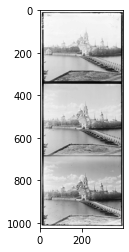

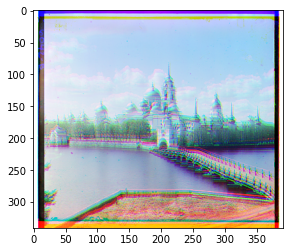

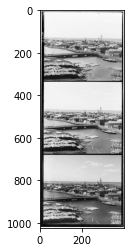

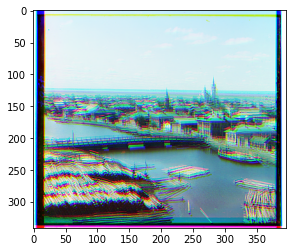

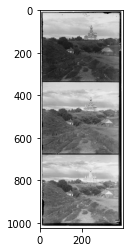

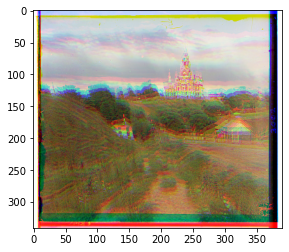

In [99]:
num_imgs = 3
for n in range(num_imgs):
    # read and display input file
    im = cv2.imread(str(images_low_res[n]), cv2.IMREAD_GRAYSCALE)
    plt.figure()
    plt.imshow(im, cmap=plt.get_cmap("gray"))

    # align channels
    B_start = 0
    G_start, R_start = align_with(im, align_basic)
    h, w = im.shape[0] // 3, im.shape[1]
    R_mat, G_mat, B_mat = channels(B_start, G_start, R_start, h, w)

    # combine channels and display result
    result = np.dstack([R_mat, G_mat, B_mat])
    plt.figure()
    plt.imshow(result)

    # save the images

    fname = out_dir / images_low_res[n].name
    Image.fromarray(result).save(fname)

### Testing high resolution images

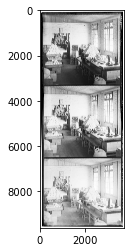

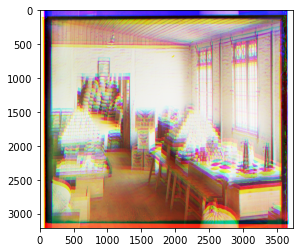

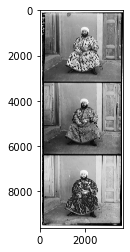

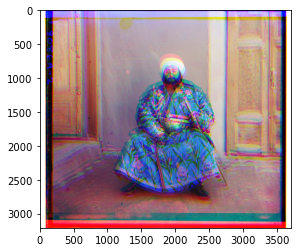

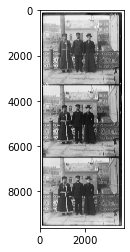

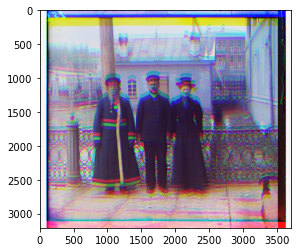

In [102]:
num_imgs = 3
for n in range(num_imgs):
    # read and display input file
    im = cv2.imread(str(images_high_res[n]), cv2.IMREAD_GRAYSCALE)
    plt.figure()
    plt.imshow(im, cmap=plt.get_cmap("gray"))

    # align channels
    B_start = 0
    G_start, R_start = align_with(im, align_basic)
    h, w = im.shape[0] // 3, im.shape[1]
    R_mat, G_mat, B_mat = channels(B_start, G_start, R_start, h, w)

    # combine channels and display result
    result = np.dstack([R_mat, G_mat, B_mat])
    plt.figure()
    plt.imshow(result)

    # save the images

    fname = out_dir / images_high_res[n].name
    Image.fromarray(result).save(fname)